In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv("data/deponieanlieferungen-tufentobel.csv", delimiter=';')

#Check for missing values
missing_values = df.isna().sum()
missing_values

#missing values are in column "Kanton" with only 94 values missing
#also, the there are no relevant outliers in these 94 values
df[df['Kanton'].isna()].describe()

#drop missing values for Kanton
df.dropna(subset=['Kanton'], inplace=True)

#check where the anlieferungen are zero tons
df[df['Gewicht in Tonnen'] == 0].value_counts().sum()

#remove these values
df.drop(df[df['Gewicht in Tonnen'] == 0].index, inplace=True)

#test if it worked
df[df['Gewicht in Tonnen'] == 0].value_counts().sum()

#check very small values
#print(df[df['Gewicht in Tonnen'] < 0.1].value_counts().sum())

#check duplicates
duplicates = df.duplicated()
#print(f"Number of duplicate rows: {duplicates.sum()}")

# #Visualize the outliers in a plot
# plt.figure(figsize=(10, 6))
# plt.boxplot(df['Gewicht in Tonnen'], vert=False)
# plt.title('Boxplot of Gewicht in Tonnen')
# plt.xlabel('Gewicht in Tonnen')
# plt.show()


# df[df['Gewicht in Tonnen'] > 35]

#there is one outlier with 56.7 tons, the other values dont go over 35 tons
#remove this outlier
df.drop(df[df['Gewicht in Tonnen'] > 50].index, inplace=True)

#Time series decomposition

# Convert the date column to datetime
df['Anlieferungsdatum'] = pd.to_datetime(df['Anlieferungsdatum'], utc=True)

# # Set the date column as the index
df.set_index('Anlieferungsdatum', inplace=True)

In [111]:
df = df[["Gewicht in Tonnen"]]
# df = df.resample('D').sum()

In [112]:
daily_data = df['Gewicht in Tonnen'].resample('D').sum()
daily_data.replace(0, np.nan, inplace=True)
daily_data = daily_data.interpolate(method='time')
daily_data

Anlieferungsdatum
2019-01-03 00:00:00+00:00      73.040000
2019-01-04 00:00:00+00:00      72.580000
2019-01-05 00:00:00+00:00     771.026667
2019-01-06 00:00:00+00:00    1469.473333
2019-01-07 00:00:00+00:00    2167.920000
                                ...     
2024-02-24 00:00:00+00:00    1029.506667
2024-02-25 00:00:00+00:00    1782.053333
2024-02-26 00:00:00+00:00    2534.600000
2024-02-27 00:00:00+00:00    1549.240000
2024-02-28 00:00:00+00:00     915.640000
Freq: D, Name: Gewicht in Tonnen, Length: 1883, dtype: float64

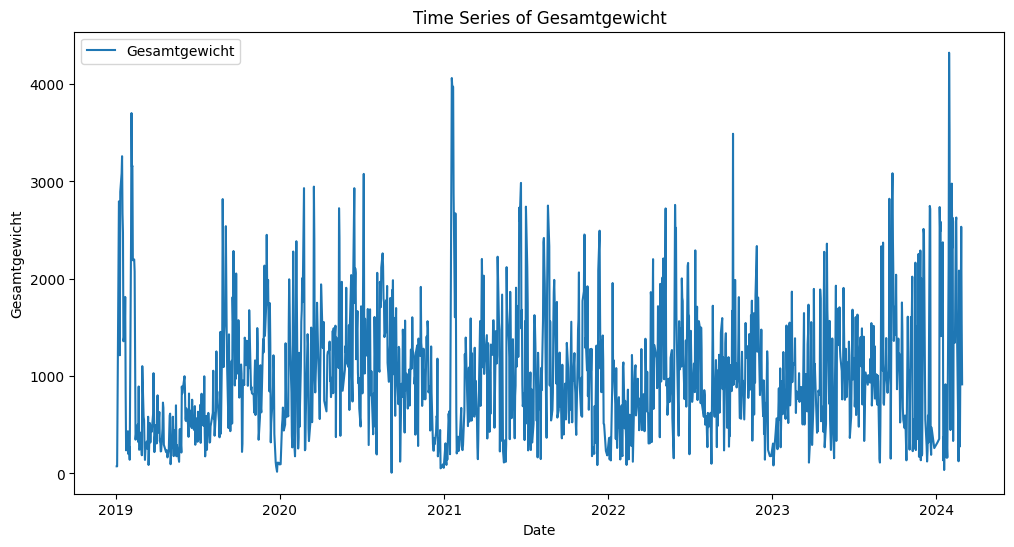

In [113]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data, label='Gesamtgewicht')
plt.title('Time Series of Gesamtgewicht')
plt.xlabel('Date')
plt.ylabel('Gesamtgewicht')
plt.legend()
plt.show()

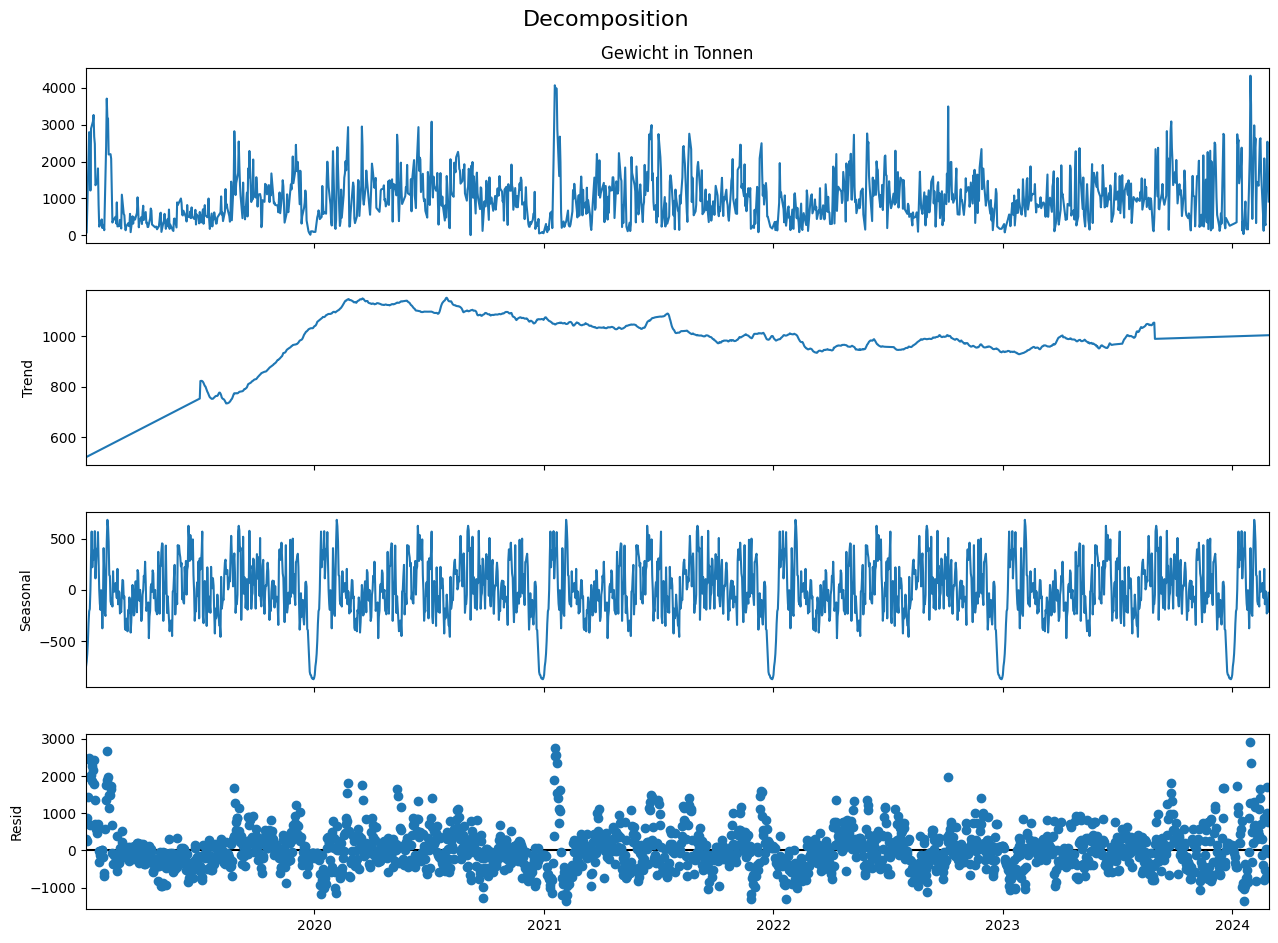

In [169]:

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, model='additive', period=365, extrapolate_trend='freq')

# Plot the decomposition
# Extract trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Decomposition', fontsize=16)
plt.show()

Decomposition

In [115]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(daily_data)

# Extract and print the test statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print("Critical Values:", adf_result[4])

ADF Statistic: -11.1276167773363
p-value: 3.343487247236552e-20
Critical Values: {'1%': np.float64(-3.433838687021998), '5%': np.float64(-2.863081058653235), '10%': np.float64(-2.567590403056488)}


The ADF Statistic 
−
6.1059
−6.1059 is more negative than the critical values at all levels (1%, 5%, 10%).
The p-value is much smaller than 
0.05
0.05, providing strong evidence to reject the null hypothesis.
Conclusion:
The time series is stationary at all commonly used significance levels.

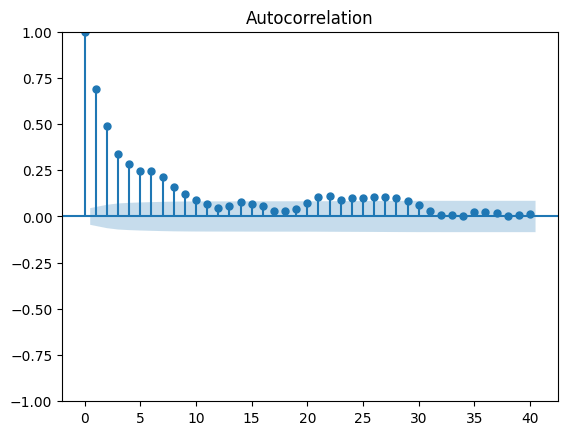

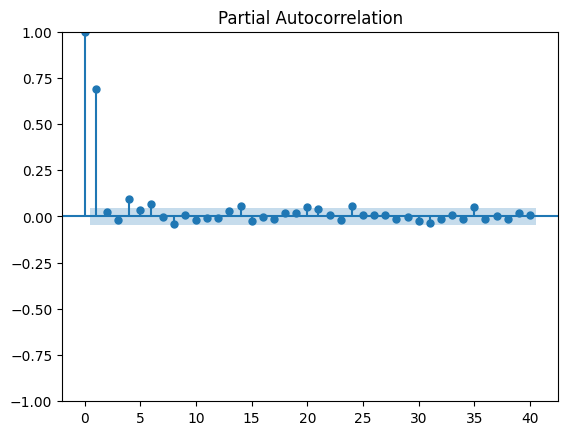

In [116]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(daily_data, lags=40)
plot_pacf(daily_data, lags=40)
plt.show()

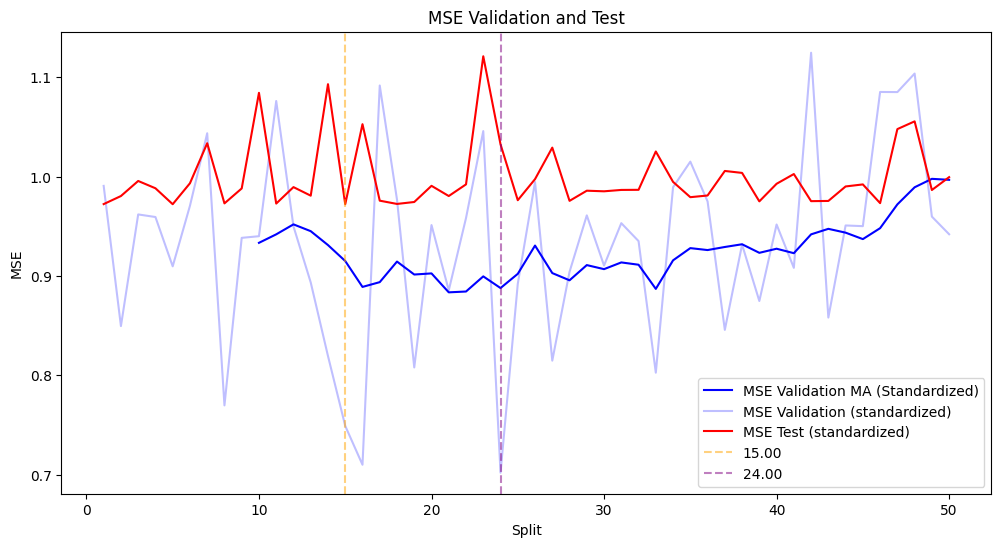

In [168]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# --- 1. Daten laden ---
# Beispiel: daily_data = pd.Series(...) (Deine Zeitreihe)

# --- 2. Saisonalität und Trend extrahieren ---
# Additive Dekomposition
# decomposition = sm.tsa.seasonal_decompose(daily_data, model='additive', period=365, extrapolate_trend='freq')
# trend = decomposition.trend
# seasonal = decomposition.seasonal

# --- 3. ARIMA-Parameter ---
p, d, q = 2, 0, 0

# --- 4. Daten-Splitting ---
test_size = 100  # Größe des unabhängigen Tests
validate_size = 20  # Größe jedes Validation-Splits
train_validate_size = len(daily_data) - test_size  # Rest als Train + Validate

# Daten aufteilen
train_validate_data = daily_data[:train_validate_size]
test_data = daily_data[train_validate_size:]
trend_train_validate = trend[:train_validate_size]
trend_test = trend[train_validate_size:]
seasonal_train_validate = seasonal[:train_validate_size]
seasonal_test = seasonal[train_validate_size:]

# --- 5. Rolling Validation ---
n_splits = 50
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=validate_size)

# Error lists
colors = ["red", "blue", "green", "orange"]

validate_errors = []
standardized_validate_errors = []
standardized_test_errors = []

# TESTING
# Detrend und Deseasonalize
test_residual = test_data - trend_test - seasonal_test
# Standardize
test_mean, test_std = test_residual.mean(), test_residual.std()
test_standardized = (test_residual - test_mean) / test_std

plt.figure(figsize=(12, 6))
# --- 6. Training und Validierung ---
for i, (train_index, validate_index) in enumerate(tscv.split(train_validate_data)):
    # print(f"Split {i+1}/{n_splits}")
    # Train und Validate Splits erstellen
    train, validate = train_validate_data.iloc[train_index], train_validate_data.iloc[validate_index]
    trend_train, trend_validate = trend_train_validate.iloc[train_index], trend_train_validate.iloc[validate_index]
    seasonal_train, seasonal_validate = seasonal_train_validate.iloc[train_index], seasonal_train_validate.iloc[validate_index]
    
    # TRAINING
    # Detrend und Deseasonalize
    train_residual = train - trend_train - seasonal_train
    # Standardize
    train_mean, train_std = train_residual.mean(), train_residual.std()
    train_standardized = (train_residual - train_mean) / train_std
    
    # VALIDATION
    # Detrend und Deseasonalize
    validate_residual = validate - trend_validate - seasonal_validate
    # Standardize
    validate_mean, validate_std = validate_residual.mean(), validate_residual.std()
    validate_standardized = (validate_residual - validate_mean) / validate_std

    # Fit ARIMA-model on training split
    model = ARIMA(train_standardized, order=(p, d, q))
    model_fit = model.fit()
    
    # Vorhersage auf Validation-Split
    forecast_standardized = model_fit.forecast(steps=len(validate_standardized))

    # Validationsfehler (Standardized)
    standardized_error = mean_squared_error(validate_standardized, forecast_standardized)
    # print(f"Validation Error (Standardized): {standardized_error}")
    standardized_validate_errors.append(standardized_error)

    # TEST
    # Vorhersage auf Test-Split
    forecast_test_standardized = model_fit.forecast(steps=len(test_standardized))

    # Testfehler (Standardized)
    test_error = mean_squared_error(test_standardized, forecast_test_standardized)
    standardized_test_errors.append(test_error)

# --- 8. Plot Test Results ---
# Plot something
window_size = 10
moving_avg_errors = pd.Series(standardized_validate_errors).rolling(window=window_size).mean()
plt.plot(range(1, n_splits+1), moving_avg_errors, label="MSE Validation MA (Standardized)", color='blue')
plt.plot(range(1, n_splits+1), standardized_validate_errors, label="MSE Validation (standardized)", color='blue', alpha=0.25)
plt.plot(range(1, n_splits+1), standardized_test_errors, label="MSE Test (standardized)", color='red')

# Find the split with the lowest standardized test error
min_error_index = standardized_test_errors.index(min(standardized_test_errors)) + 1
min_error_value = min(standardized_test_errors)
min_valerror_index = standardized_validate_errors.index(min(standardized_validate_errors)) + 1
min_valerror_value = min(standardized_validate_errors)

# Plot vertical and horizontal lines at the minimum error
plt.axvline(x=min_error_index, color='orange', alpha=0.5, linestyle='--', label=f'{min_error_index:.2f}')

# Plot vertical and horizontal lines at the minimum error
plt.axvline(x=min_valerror_index, color='purple', alpha=0.5, linestyle='--', label=f'{min_valerror_index:.2f}')

plt.title("MSE Validation and Test")
plt.xlabel("Split")
plt.ylabel("MSE")
plt.legend()
plt.show()